In [6]:
TEST_DATA_PATH = 'sarcastic-headlines/Sarcasm_Headlines_Dataset.json'
TEST_DATA_PATH_2 = 'sarcastic-headlines/Sarcasm_Headlines_Dataset_v2.json'
data_1 = pd.read_json(TEST_DATA_PATH, lines=True)
data_2 = pd.read_json(TEST_DATA_PATH_2, lines=True)
data = pd.concat([data_1, data_2])
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
28614,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
28615,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
28616,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
28617,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

In [9]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [47]:
data['is_sarcastic'].value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

In [10]:
def clean_text(df, column_name):
    all_reviews = list()
    lines = df[column_name].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

In [37]:
all_data = clean_text(data, "headline")

In [38]:
all_data[0:5]

['former versace store clerk sues over secret black code for minority shoppers',
 'the roseanne revival catches up to our thorny political mood for better and worse',
 'mom starting to fear son s web series closest thing she will have to grandchild',
 'boehner just wants wife to listen not come up with alternative debtreduction ideas',
 'jk rowling wishes snape happy birthday in the most magical way']

In [41]:
data["headline"] = all_data
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret bl...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the roseanne revival catches up to our thorny ...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son s web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner just wants wife to listen not come up ...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wishes snape happy birthday in the ...,0
...,...,...,...
28614,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
28615,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
28616,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
28617,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberggate...,1


In [50]:
data_train, data_test, datay_train, datay_test = \
    train_test_split(data['headline'], data['is_sarcastic'], random_state=17)

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [18]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(64, activation='sigmoid')(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [19]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [51]:
model.fit(data_train, datay_train, epochs=10)

Epoch 1/10
1297/1297 [==============================] - 8252s 6s/step - loss: 0.5441 - accuracy: 0.7278 - precision: 0.7317 - recall: 0.6434
Epoch 2/10
1297/1297 [==============================] - 7698s 6s/step - loss: 0.4881 - accuracy: 0.7655 - precision: 0.7601 - recall: 0.7154
Epoch 3/10
1297/1297 [==============================] - 7722s 6s/step - loss: 0.4715 - accuracy: 0.7724 - precision: 0.7671 - recall: 0.7246
Epoch 4/10
1297/1297 [==============================] - 7903s 6s/step - loss: 0.4654 - accuracy: 0.7764 - precision: 0.7695 - recall: 0.7330
Epoch 5/10
1297/1297 [==============================] - 7753s 6s/step - loss: 0.4559 - accuracy: 0.7812 - precision: 0.7735 - recall: 0.7407
Epoch 6/10
1297/1297 [==============================] - 7577s 6s/step - loss: 0.4537 - accuracy: 0.7828 - precision: 0.7725 - recall: 0.7473
Epoch 7/10
1297/1297 [==============================] - 7446s 6s/step - loss: 0.4509 - accuracy: 0.7844 - precision: 0.7728 - recall: 0.7517
Epoch 8/10
12

In [52]:
model.evaluate(data_test, datay_test)

433/433 [==============================] - 2633s 6s/step - loss: 0.4115 - accuracy: 0.8151 - precision: 0.7990 - recall: 0.7931


[0.41148683428764343,
 0.8151388168334961,
 0.7990392446517944,
 0.7930705547332764]

In [53]:
y_predicted = model.predict(data_test)
y_predicted = y_predicted.flatten()

433/433 [==============================] - 2731s 6s/step


In [56]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted[0:100]

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [58]:
cm = confusion_matrix(datay_test, y_predicted)
cm 

array([[6285, 1255],
       [1302, 4990]], dtype=int64)

Text(33.0, 0.5, 'Truth')

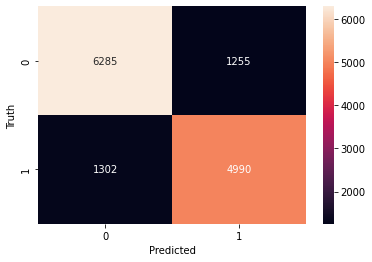

In [61]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
print(classification_report(datay_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7540
           1       0.80      0.79      0.80      6292

    accuracy                           0.82     13832
   macro avg       0.81      0.81      0.81     13832
weighted avg       0.82      0.82      0.82     13832



In [20]:
def is_sarcastic(sentence):
    x = pd.DataFrame({"headline":[sentence]})
    predict = loaded_model.predict(x)
    predict*=100
    if predict[0][0]>=50:
        return "Sarcastic"

    else:
        return "Not sarcastic"

In [100]:
is_sarcastic("Ford develops new SUV that runs purely on gasoline")

1/1 [==============================] - 0s 399ms/step


'Sarcastic'

In [98]:
is_sarcastic("Guard in video game under strict orders to repeatedly pace same stretch of hallway.")

1/1 [==============================] - 0s 292ms/step


'Sarcastic'

In [99]:
is_sarcastic("Man with no real-life career goals knows exact job he'd want in Harry Potter universe")

1/1 [==============================] - 0s 304ms/step


'Sarcastic'

In [117]:
is_sarcastic("God said He is reducing eternal life to 500 billion years")

1/1 [==============================] - 0s 281ms/step


'Sarcastic'

In [102]:
is_sarcastic("Man's only contribution to house search is periodically telling wife he wishes he knew how to help.")

1/1 [==============================] - 0s 272ms/step


'Sarcastic'

In [103]:
is_sarcastic("Sudanese elephant trying to forget")

1/1 [==============================] - 0s 269ms/step


'Sarcastic'

In [105]:
is_sarcastic("You have my missing watch all this time? Why didn't you say you've borrowed it?")

1/1 [==============================] - 0s 274ms/step


'Not sarcastic'

In [132]:
is_sarcastic("The mess you've made in the kitchen can't be cleaned. Great job!")

1/1 [==============================] - 0s 452ms/step


'Not sarcastic'

In [111]:
is_sarcastic("Baby, I saw you with another man yesterday. I love you.")

1/1 [==============================] - 0s 288ms/step


'Not sarcastic'

In [114]:
is_sarcastic("Girlfriend acting all clingy after getting pregnant.")

1/1 [==============================] - 0s 287ms/step


'Sarcastic'

In [115]:
is_sarcastic("Student went missing just before exam starts.")

1/1 [==============================] - 0s 278ms/step


'Sarcastic'

In [133]:
model.save('models/sarcasm-detection-model.h5')

In [3]:
from tensorflow.keras.models import load_model

In [4]:
loaded_model = load_model('models/sarcasm-detection-model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [5]:
loaded_model.predict(["Student went missing just before exam starts"])

1/1 [==============================] - 1s 1s/step


array([[0.60405046]], dtype=float32)

In [45]:
is_sarcastic("No rise in COVID-19 cases in Ilocos region after elections")

1/1 [==============================] - 0s 255ms/step


'Not sarcastic'